# Practice Lab: Neural Networks for Handwritten Digit Recognition, Binary

In this exercise, you will use a neural network to recognize the hand-written digits zero and one.


# Outline
- [ 1 - Packages ](#1)
- [ 2 - Neural Networks](#2)
  - [ 2.1 Problem Statement](#2.1)
  - [ 2.2 Dataset](#2.2)
  - [ 2.3 Model representation](#2.3)
  - [ 2.4 Tensorflow Model Implementation](#2.4)
    - [ Exercise 1](#ex01)
  - [ 2.5 NumPy Model Implementation (Forward Prop in NumPy)](#2.5)
    - [ Exercise 2](#ex02)
  - [ 2.6 Vectorized NumPy Model Implementation (Optional)](#2.6)
    - [ Exercise 3](#ex03)
  - [ 2.7 Congratulations!](#2.7)
  - [ 2.8 NumPy Broadcasting Tutorial (Optional)](#2.8)


_**NOTE:** To prevent errors from the autograder, you are not allowed to edit or delete non-graded cells in this notebook . Please also refrain from adding any new cells. 
**Once you have passed this assignment** and want to experiment with any of the non-graded code, you may follow the instructions at the bottom of this notebook._

<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [222]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense # type: ignore
import matplotlib.pyplot as plt
from autils import *
%matplotlib inline

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

**Tensorflow and Keras**  
Tensorflow is a machine learning package developed by Google. In 2019, Google integrated Keras into Tensorflow and released Tensorflow 2.0. Keras is a framework developed independently by François Chollet that creates a simple, layer-centric interface to Tensorflow. This course will be using the Keras interface. 

<a name="2"></a>
## 2 - Neural Networks

In Course 1, you implemented logistic regression, which was then extended to handle non-linear decision boundaries using polynomial regression. For more complex tasks, such as image recognition, neural networks are typically preferred.


<details>
  <summary><b style="color:red;">Polynomial Logistic Regression</b></summary>

#### **🟣 Logistic Regression with Polynomial Features: Modeling Non-Linear Decision Boundaries**

##### **Problem:**

Suppose you want to classify whether a point $(x_1, x_2)$ is **inside a circle of radius 1** centered at the origin.

The exact mathematical condition is:
$$
x_1^2 + x_2^2 \leq 1
$$

A **linear** logistic regression model struggles here: it can only separate data with a straight line, not a curve.

##### **Polynomial Features**

To handle this, **extend logistic regression** by adding polynomial features.  
Instead of using just $[x_1, x_2]$, form a new input vector:
$$
\text{input} = [1,\, x_1,\, x_2,\, x_1^2,\, x_2^2]
$$
- This allows logistic regression to learn **curved decision boundaries** (like circles or ellipses).

##### **Example Code (with sklearn)**
```python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

# Use numpy's random generator
rng = np.random.default_rng(seed=0)
X = rng.uniform(-1.5, 1.5, (300, 2)) #It creates a NumPy array X of shape (300, 2) using a uniform distribution in the range -1.5 to 1.5
Y = ((X[:, 0]**2 + X[:, 1]**2) < 1).astype(int) #Y is the label: 1 if the point is inside the unit circle (x^2 + y^2 < 1), otherwise 0.

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=True)
X_poly = poly.fit_transform(X) #X_poly.shape = (300,6).  type(X_poly) = numpy.ndarray
'''
- PolynomialFeatures(degree=2) creates a transformer that will generate all polynomial combinations of the input features up to degree 2.
- include_bias=True adds a column of ones (bias term / intercept).
- fit_transform(X) takes your input X of shape (300, 2) and creates a new feature matrix X_poly of shape (300, 6). If your features are x_1 and x_2, then X_poly will be: 
[1, x_1, x_2, x_1^2, x_1 x_2, x_2^2]
'''

# Train the logistic regression model
clf = LogisticRegression()
clf.fit(X_poly, Y) #Train the classifier using the polynomially extended data
'''
What it does:
- Initializes a logistic regression model clf.
- clf.fit(X_poly, Y) trains the model to classify the labels Y based on the expanded features X_poly.
'''

# Plot the data points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='coolwarm', edgecolors='k')
plt.title("Points inside circle (Y=1) vs outside (Y=0)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()
```

##### **Key Idea**
- Using polynomial features allows the logistic regression model to learn non-linear decision boundaries — like circles or curves — even though logistic regression itself is a linear model. In this case, you're enabling it to learn a circular boundary (since the true label is based on distance from the origin).  
- Even though your target pattern (e.g. a circle) doesn't need the cross-term $x_1⋅x_2$, logistic regression is still a linear model over the features. So if the model realizes the $x_1⋅x_2$ term doesn't help, it will learn a small (near-zero) weight for it. 
- Adding non-linear terms (like $x_1^2$, $x_2^2$ or $x_1⋅x_2$) lets logistic regression develop **non-linear decision boundaries**.
- This is called **polynomial logistic regression** and is a simple way to tackle non-linear classification problems!


</details>




<a name="2.1"></a>
### 2.1 Problem Statement

In this exercise, you will use a neural network to recognize two handwritten digits: zero and one. This is a binary classification task. Automated handwritten digit recognition is widely used today — from reading zip codes (postal codes) on mail envelopes to interpreting amounts written on bank checks. In a future assignment, you will extend this network to recognize all 10 digits (0–9).

This exercise demonstrates how the methods you've learned can be applied to a real-world classification task.

<a name="2.2"></a>
### 2.2 Dataset

You will begin by loading the dataset for this task.
- The `load_data()` function shown below loads the data into the variables `X` and `y`.


- The dataset contains 1000 training examples of handwritten digits $^1$, limited here to the digits zero and one.

    - Each training example is a 20 × 20 pixel grayscale image of a digit.
        - Each pixel is represented by a floating-point number indicating the grayscale intensity at that location.
        - The 20 × 20 grid of pixels is “unrolled” into a 400-dimensional vector.
        - Each training example becomes a single row in the data matrix `X`. 
        - This results in a 1,000 × 400 matrix `X`, where each row is a training example of a handwritten digit image:

$$X = 
\left(\begin{array}{cc} 
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\ 
--- (x^{(m)}) --- 
\end{array}\right)$$ 

- The second part of the training set is a 1,000 × 1 vector `y` containing the labels for the training set:
    - `y = 0` if the image is of the digit `0`
    - `y = 1` if the image is of the digit `1`.

$^1$<sub> This is a subset of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/)</sub>

<details>
  <summary><b style="color:red;">Shouldn't the input data matrix <code>X</code> include a column of ones to account for the bias term?</b></summary>

Great question.

In traditional **linear models** like logistic regression (especially when implemented from scratch), we manually add a column of ones to the input data matrix `X` to account for the **bias term** (intercept).  

For example:
```python
X = np.hstack([np.ones((m, 1)), X])  # Add a column of 1s as the first column
``` 
However, in frameworks like TensorFlow, Keras, or Scikit-learn, you do not need to add this column yourself.  

✅ **Why?**

Because these libraries handle the **bias term internally**:  
The bias is a separate parameter ($b$) in layers like `Dense` (Keras) or models like `LogisticRegression` (Scikit-learn).  

Therefore, the input data matrix **$X$ is *not* required to have a column of ones**.

So, to answer your question:  
*"Shouldn't the input data matrix <code>X</code> include a column of ones to account for the bias term?"*

❌ **No**, not when you're using Scikit-learn's `LogisticRegression`, TensorFlow, or any high-level ML API — the model **includes and learns the bias automatically**.

If you were implementing the model yourself (e.g., writing the full cost function and gradient descent), then yes, you might add a **column of ones explicitly** to $X$.

</details>


In [223]:
# load dataset
X, y = load_data()

In [224]:
# type(X) #numpy.ndarray
# X.shape #(1000, 400)
# y.shape #(1000, 1)

<a name="toc_89367_2.2.1"></a>
#### 2.2.1 View the variables
Let's get more familiar with your dataset.  
- A good place to start is to print out each variable and see what it contains.

The code below prints elements of the variables `X` and `y`.  

In [225]:
print ('The first element of X is: ', X[0])  #X[0]: returns the first row of the matrix (the first training example).
X[0].shape

The first element of X is:  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+

(400,)

In [226]:
print ('The first element of y is: ', y[0,0])
print ('The last element of y is: ', y[-1,0])

The first element of y is:  0
The last element of y is:  1


<a name="toc_89367_2.2.2"></a>
#### 2.2.2 Check the dimensions of your variables

Another way to get familiar with your data is to view its dimensions. Please print the shape of `X` and `y` and see how many training examples you have in your dataset.

In [227]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of y is: ' + str(y.shape))
# so we have 1000 training examples in our dataset.

The shape of X is: (1000, 400)
The shape of y is: (1000, 1)


<a name="toc_89367_2.2.3"></a>
#### 2.2.3 Visualizing the Data

You will begin by visualizing a subset of the training set. 
- In the cell below, the code randomly selects 64 rows from `X`, maps each row back to a 20 pixel by 20 pixel grayscale image and displays the images together. 
- The label for each image is displayed above the image 

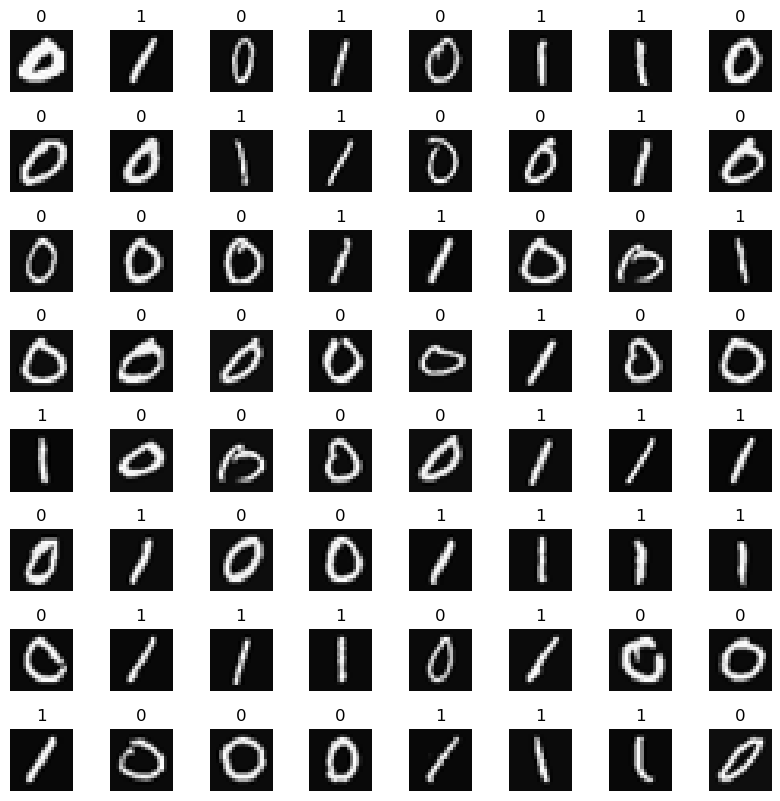

In [228]:
# This block of code displays 64 randomly selected images (8×8 grid) from a dataset of 
# handwritten digits, specifically 20x20 grayscale images of digits 0 or 1, such as from the MNIST subset. 


import warnings #Used to control the display of warnings in Python.
warnings.simplefilter(action='ignore', category=FutureWarning) #This line suppresses FutureWarnings, which are harmless but often noisy warnings about features that might change in future Python/Numpy versions.

m, n = X.shape
'''
This retrieves:
    m: number of training examples (e.g., 1000)
    n: number of features per example (should be 400 for 20x20 images)
'''

fig, axes = plt.subplots(8,8, figsize=(8,8)) #This creates an 8×8 grid of subplots → total of 64 plots.
fig.tight_layout(pad=0.1) #It adds a tiny bit of space between plots.

# Looping through the subplots:
for i,ax in enumerate(axes.flat): #axes.flat flattens the 2D axes array so we can iterate over all 64 axes easily.
    # Select random indices
    random_index = np.random.randint(m) #Chooses a random row index from the dataset (0 ≤ index < m).
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T #Takes the flattened 400-element image vector and reshapes it into a 20×20 image and .T transposes the image so it’s oriented correctly for display.
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray') #Displays the reshaped image using a grayscale color map.
    
    # Display the label above the image
    ax.set_title(y[random_index,0])
    ax.set_axis_off()

# list(enumerate(axes.flat))
#output:
# [(0, <Axes: title={'center': '1'}>),
#  (1, <Axes: title={'center': '1'}>),
#  (2, <Axes: title={'center': '1'}>),
#  (3, <Axes: title={'center': '0'}>),
#  ...
#  (62, <Axes: title={'center': '0'}>),
#  (63, <Axes: title={'center': '1'}>)]

<a name="2.3"></a>
### 2.3 Model representation

The neural network you will use in this assignment is shown in the figure below. 
- This has three dense layers with sigmoid activations.
    - Recall that our inputs are pixel values of digit images.
    - Since the images are of size $20\times20$, this gives us $400$ inputs  
    
<img src="images/C2_W1_Assign1.PNG" width="500" height="400">

- The parameters are sized for a neural network with 25 units in layer 1, 15 units in layer 2, and 1 output unit in layer 3.

    - Recall that the dimensions of these parameters are determined as follows:
        - If a layer has $s_{in}$ units and the next layer has $s_{out}$, then:
            - $W$ will have the shape $(s_{\text{in}}, s_{\text{out}})$.
            - $b$ will be a vector with $s_{out}$ elements
  
    - Therefore, the shapes of `W`, and `b`,  are: 
        - layer1: `W1`→ (400, 25), `b1`→ (25,)
        - layer2: `W2` → (25, 15), `b2`→ (15,)
        - layer3: `W3`→ (15, 1), `b3`→ (1,)
>**Note:** The bias vector `b` can be represented either as a 1-D array of shape (n,) or as a 2-D array of shape (1,n). Tensorflow utilizes a 1-D format, and this lab follows that convention.
               

<a name="2.4"></a>
### 2.4 Tensorflow Model Implementation


TensorFlow models are constructed layer by layer. The input dimensions of each layer ($s_{in}$) are inferred automatically by TensorFlow. You only need to specify the output dimensions of each layer ($s_{out}$)—this then becomes the input dimension for the following layer. 
The input dimension of the first layer is determined from the shape of the input data passed to the`model.fit()`call. 
>**Note:** You can also explicitly define the input shape by adding an input layer. For example: 
```python
tf.keras.Input(shape=(400,))  # specify input shape
``` 
This can be useful for clarity and for inspecting model dimensions during construction. We'll include this here to better illustrate how model sizing works.

<a name="ex01"></a>
### Exercise 1

Below, using Keras [Sequential model](https://keras.io/guides/sequential_model/) and [Dense Layer](https://keras.io/api/layers/core_layers/dense/) with a sigmoid activation to construct the network described above.

In [229]:
# UNQ_C1
# GRADED CELL: Sequential model

model = Sequential(
    [               
        tf.keras.Input(shape=(400,)),    #specify input size
        ### START CODE HERE ### 
        Dense(25, activation='sigmoid', name = 'Layer1'),
        Dense(15, activation='sigmoid', name = 'Layer2'),
        Dense(1, activation='sigmoid', name = 'Layer3'),
        ### END CODE HERE ### 
    ], name = "my_model" 
)                            


In [230]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Layer1 (Dense)                  │ (None, 25)             │        10,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer2 (Dense)                  │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer3 (Dense)                  │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,431 (40.75 KB)

 Trainable params: 10,431 (40.75 KB)

 Non-trainable params: 0 (0.00 B)

1. **We defined the model:**  

  ```python
  model = Sequential([...])
  ```
  This sets up the architecture, but does not instantiate weights and biases yet.

2. **Then we ran:**  

  ```python
  model.summary()
  ```
  This **does trigger model building** if the input shape is specified (which we did via `tf.keras.Input(shape=(400,))` in the previous step).

  ✅ So at this point:
  - The model is built. 
  - The layers now have weights and biases instantiated (initialized).

  We’ll see output shapes and parameter counts in the summary.  

<details>
  <summary><font size="3" color="darkgreen"><b>Expected Output (Click to Expand) </b></font></summary>
The `model.summary()` function displays a useful summary of the model. Because we have specified an input layer size, the shape of the weight and bias arrays are determined and the total number of parameters per layer can be shown. Note, the names of the layers may vary as they are auto-generated.  
    
    
```
Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense (Dense)                (None, 25)                10025     
_________________________________________________________________
dense_1 (Dense)              (None, 15)                390       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
=================================================================
Total params: 10,431
Trainable params: 10,431
Non-trainable params: 0
_________________________________________________________________
```

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
As described in the lecture:
    
```python
model = Sequential(                      
    [                                   
        tf.keras.Input(shape=(400,)),    # specify input size (optional)
        Dense(25, activation='sigmoid'), 
        Dense(15, activation='sigmoid'), 
        Dense(1,  activation='sigmoid')  
    ], name = "my_model"                                    
)                                       
``` 

In [231]:
# # UNIT TESTS
# from public_tests import *

# test_c1(model)

<details>
  <summary><b style="color:red;">why I got an error?</b></summary>

When I run the previous cell, I get an error. This error means that while our model has been defined, it **has not yet been called with any input data**. As a result, its input shape hasn't been set, and therefore `model.input` does not exist yet.

**What Caused the Error?**

Inside `test_c1(model)`, this line caused the error:
```python
target.input.shape.as_list()
```
This tries to access the model’s input tensor (`model.input`), but at this moment, the model had **never been called with any data**, so TensorFlow raises an `AttributeError`:

> "The layer *my_model* has never been called and thus has no defined input."

- `my_model` is the name of our **whole model**, not an internal layer.
- The error means:  
  *“You haven’t passed any input to your model yet, so I can’t give you `.input`.”*

🤔 **But Why Did `model.summary()` Work Before?**

Good question.  
When you define a model with an explicit input shape using:
```python
model = Sequential([
tf.keras.Input(shape=(400,)),
Dense(...),
...
])
```
- TensorFlow knows the **structure** of your model.
- So `model.summary()` can show the model architecture (layers, shapes, parameters).  
- ✅ `model.summary()` works based on **shape declarations**.  
- ❌ But `model.input` is **not created** until the model is called with actual data, like:
```python
model(tf.zeros((1, 400)))
```
🔥 **The Catch: `.summary()` vs `.input`**

- ✅ `model.summary()` relies on the **shape definitions** and works if you’ve defined the input shape.  
- ❌ `model.input` requires that the model has been **called with actual data**, or you’ve manually **built** it, so TensorFlow can trace the computation graph and bind inputs.

**That's why this works:**
```python
model.summary() # ✅ OK
```
**But this fails:**
```python
model.input.shape.as_list() # ❌ AttributeError
```
✅ **Solution**

To make `model.input` available and avoid the error in `test_c1(model)`, you must call the model at least once:
```python
dummy_input = tf.zeros((1, 400), dtype=tf.float32)
model(dummy_input) # this binds the input and output tensors
test_c1(model) # now it will work
```
#### **Note**:
```python
model(tf.zeros((400,))) ❌ Incorrect
```
Even though you said `shape=(400,)` in your model:
```python
tf.keras.Input(shape=(400,))
```
, you still need to wrap it in a batch when calling the model. Always pass input of shape (batch_size, 400) — even if batch_size is 1.   

🔴 Why `model(tf.zeros((400,)))` fails:  

`tf.zeros((400,))` is a 1D tensor, shape `(400,)` → one feature vector with no batch dimension.
The model expects a **2D input of shape (1, 400) or (m, 400)**.
</details>

In [232]:
# dummy_input = tf.zeros((1, 400), dtype=tf.float32)
# model(dummy_input)
# test_c1(model)


The parameter counts displayed in the summary reflect the total number of elements in the weight and bias arrays, as illustrated below:

In [233]:
L1_num_params = 400 * 25 + 25  # W1 parameters  + b1 parameters
L2_num_params = 25 * 15 + 15   # W2 parameters  + b2 parameters
L3_num_params = 15 * 1 + 1     # W3 parameters  + b3 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params, ",  L3 params = ", L3_num_params)

L1 params =  10025 , L2 params =  390 ,  L3 params =  16


We can examine details of the model by first extracting the layers with `model.layers` and then extracting the weights with `layerx.get_weights()` as shown below.

In [234]:
[layer1, layer2, layer3] = model.layers
#or
# W1, b1 = model.get_layer("Layer1").get_weights()
# W2, b2 = model.get_layer("Layer2").get_weights()
# W3, b3 = model.get_layer("Layer3").get_weights()

In [235]:
#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 1), b3 shape = (1,)


**Expected Output**
```
W1 shape = (400, 25), b1 shape = (25,)  
W2 shape = (25, 15), b2 shape = (15,)  
W3 shape = (15, 1), b3 shape = (1,)
```

`xx.get_weights` returns a NumPy array. One can also access the weights directly in their tensor form. Note the shape of the tensors in the final layer.

In [236]:
print(model.layers[2].weights)
# Accesses the third layer of your model (index 2, since Python is 0-indexed).
# Prints the list of trainable weight tensors (i.e., W and b) for that layer.

# will output something like:
#     [<tf.Variable 'Layer3/kernel:0' shape=(15, 1) dtype=float32>,
#     <tf.Variable 'Layer3/bias:0' shape=(1,) dtype=float32>]

[<Variable path=my_model/Layer3/kernel, shape=(15, 1), dtype=float32, value=[[ 0.4732285 ]
 [-0.1701326 ]
 [ 0.1851247 ]
 [-0.56278306]
 [ 0.5629435 ]
 [ 0.14095837]
 [ 0.10010135]
 [-0.18270808]
 [ 0.34035456]
 [ 0.6044608 ]
 [ 0.24470258]
 [ 0.04769427]
 [ 0.6028008 ]
 [ 0.00526595]
 [ 0.24568868]]>, <Variable path=my_model/Layer3/bias, shape=(1,), dtype=float32, value=[0.]>]


The following code will define a loss function and run gradient descent to fit the weights of the model to the training data. This will be explained in more detail in the following week.

In [237]:
X.shape

(1000, 400)

In [238]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
)
'''
We're telling TensorFlow how to train the model:
    Loss function: BinaryCrossentropy()
        Used for binary classification.
        Compares predicted probabilities (from the sigmoid in our output layer) with the true labels (0 or 1).

    Optimizer: Adam with learning_rate=0.01
        This controls how the weights get updated during training.
        Adam (Adaptive Moment Estimation) is a popular and adaptive optimization algorithm.

❓What if we get stuck in a local minimum?
In theory, yes, optimizers can get stuck in:
A local minimum
A saddle point (where the gradient is near zero but it’s not a minimum)
Or a flat region (plateau)

But in practice, especially with modern optimizers like Adam, it's less likely to be a major problem.
In practice:
Neural networks often don't have bad local minima, especially in high-dimensional spaces — many “local minima” are good enough.
It's saddle points and plateaus that cause more trouble, and optimizers like Adam are designed to handle those better than older methods.

'''


model.fit(
    X,y,
    epochs=20
)
'''
We start the training process:
    X: input training data (after tiling/repetition, but here we didn't do any tiling/repetition)
    y: corresponding target labels
    epochs=10: the model will see the entire dataset 20 times

🔁 What happens during training:
    For each epoch:
        The model splits X into batches (default batch size is 32).
    For each batch:
        It performs a forward pass (predicts outputs).
        Computes the loss (how wrong it was).
        Performs a backward pass (gradient computation).
        Updates the weights and biases using the Adam optimizer.
    After all batches are done, that’s one epoch.
    The process repeats for the next epoch.

🔍 Behind the scenes:
The weights W1, W2, W3 and biases b1, b2, b3 are updated after every batch.
The loss should decrease over time, assuming the model is learning.
If we print model.get_weights() now, we'll see different values from what we saw before training — the model has learned.
''';

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 0.8036
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 0.5645
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 0.4540
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 0.3531
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.2660
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.2071
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 0.1684
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 0.1416
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 0.1230
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.1056
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 0.0937
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0823 
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.0766
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.0788
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - los

In [239]:
# If we print model.get_weights() now, we'll see different values from what we saw before training — the model has learned.
print(f"W1{W1.shape}:\n", W1, f"\n\nb1{b1.shape}:", b1,'\n')
print(f"W2{W2.shape}:\n", W2, f"\n\nb2{b2.shape}:", b2, '\n')
print(f"W2{W3.shape}:\n", W3, f"\n\nb2{b3.shape}:", b3)

W1(400, 25):
 [[-0.1165916   0.04290085 -0.01054135 ... -0.11479992 -0.09935349
  -0.03090554]
 [-0.11283997 -0.08758349  0.03738016 ... -0.08602248  0.05647072
  -0.02840087]
 [-0.03056645 -0.09163869 -0.09524455 ... -0.11663662 -0.09617262
   0.06520461]
 ...
 [-0.05040735 -0.04310238 -0.08944985 ...  0.06121753  0.00576521
  -0.04304155]
 [-0.06792721  0.06242777 -0.06049694 ... -0.01427482  0.10302125
  -0.03709336]
 [ 0.09555043 -0.04614549 -0.10291791 ... -0.06735428 -0.00530647
   0.00600705]] 

b1(25,): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.] 

W2(25, 15):
 [[ 3.68877709e-01  6.20850921e-03  2.46978223e-01 -1.03486866e-01
   3.00886452e-01  1.53930902e-01  7.24110603e-02  7.08093345e-02
   3.48464787e-01  2.83522487e-01  1.07109696e-01 -8.26846957e-02
  -3.08350712e-01 -1.13946021e-01  2.45425224e-01]
 [-1.73019469e-02 -2.06847936e-01 -2.64886141e-01 -2.28158802e-01
   2.23181784e-01  5.57062030e-03  3.68972540e-01 -5.61522543e-02
  -1.0755

✅ What's Happening
Your model is correctly trained, and weights are updating.
However, your bias arrays `b1`, `b2`, and `b3` are still exactly zero because:

The optimizer hasn’t yet found it useful to update them — they're initialized to zero, and may stay zero for a while, especially if the loss is decreasing due to weight updates alone.

This is common early in training, especially when:
- The dataset is small or simple.
- The model has few epochs to train (you ran for just `epochs=20`).
- The optimizer (like Adam) focuses on weights first.

### **Once the model is trained (i.e., has learned), we use it for inference—that is, making predictions on new data**

To run the model on a single example and make a prediction, use [Keras `predict`](https://www.tensorflow.org/api_docs/python/tf/keras/Model). Since `predict` expects a batch (an array of examples), the single input must be reshaped to a 2D array.

In [248]:
X[0].shape

(400,)

In [ ]:
prediction = model.predict(X[0].reshape(1,400))  # a zero
print(f" predicting a zero: {prediction}")
prediction = model.predict(X[500].reshape(1,400))  # a one
print(f" predicting a one:  {prediction}")

# In our case, the output of the model is passed through a sigmoid activation in the final layer:
# Dense(1, activation='sigmoid')
# This means:
# The model’s output is a single number between 0 and 1.
# That number is interpreted as the probability of the positive class, which in binary classification is usually class 1.

# Therefore:
# If prediction ≈ 0, the model thinks it's very likely class 0.
# If prediction ≈ 1, the model thinks it's very likely class 1.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 predicting a zero: [[0.06025958]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
 predicting a one:  [[0.9875209]]


The output of the model is interpreted as a probability. In the first example above, the input is a zero. The model predicts the probability that the input is a one is nearly zero. 
In the second example, the input is a one. The model predicts the probability that the input is a one is nearly one.
As in the case of logistic regression, the probability is compared to a threshold to make a final prediction.

In [249]:
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print(f"prediction after threshold: {yhat}")

prediction after threshold: 1


Let's compare the predictions vs the labels for a random sample of 64 digits. This takes a moment to run.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

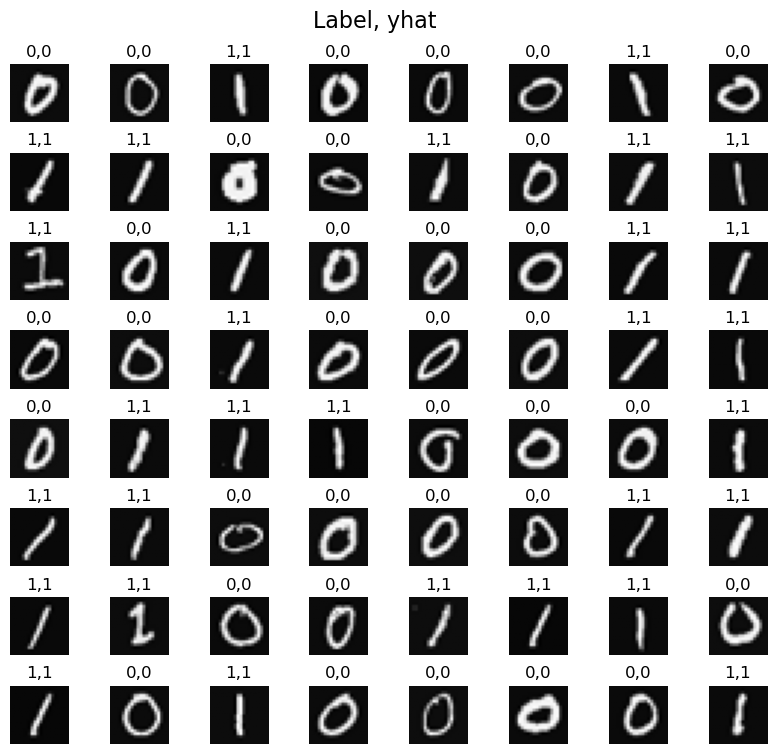

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape #(1000, 400)

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]
'''
plt.subplots(8, 8, figsize=(8, 8))
Creates a grid of subplots: 8 rows × 8 columns = 64 subplots.
fig is the overall Figure object.
axes is a 2D NumPy array of the individual Axes (i.e., the 64 small plots).
figsize=(8, 8) sets the size of the figure in inches: 8 inches wide by 8 inches tall.

🔹 fig.tight_layout(...)
Adjusts spacing between subplots automatically to reduce overlaps and improve layout.

Arguments:
pad=0.1:
Minimum padding between subplots in inches. Very tight spacing.

rect=[0, 0.03, 1, 0.92]:
This limits the layout to only a portion of the figure.

Format: [left, bottom, right, top] in relative figure coordinates (0.0 to 1.0).
So the layout is confined to:
From the left edge (0) to the right edge (1)
From just above the bottom (0.03) to slightly below the top (0.92)
This is useful when you want to leave space at the top (e.g., for a fig.suptitle()).
'''
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Predict using the Neural Network
    prediction = model.predict(X[random_index].reshape(1,400))
    if prediction >= 0.5:
        yhat = 1
    else:
        yhat = 0
    
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{yhat}")
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=16)
plt.show()

<details>
  <summary><b style="color:red;">Why the Prediction of a Trained Model on Its Training Dataset Is Not Always 100% Accurate?</b></summary>

✅ **Reasons It Might Not Be 100% Accurate:**

- **Loss Function & Optimization Limits**  
  Training aims to minimize loss, not guarantee perfect classification. Especially with non-linear, noisy, or overlapping data, the model may find a good solution without fitting every single point.

- **Regularization**  
  Techniques like dropout, L2 regularization, or early stopping intentionally prevent overfitting — which means the model won’t memorize the training data 100%.

- **Imperfect Convergence**  
  Optimization (e.g., gradient descent) may not fully converge, especially if:  
  - The learning rate is too low or too high  
  - You have too few epochs  
  - Or the architecture isn’t expressive enough

- **Noise in Training Data**  
  If the training labels have errors or inconsistencies, the model can't reach 100% accuracy without overfitting to noise.


❗ **When It Is 100% Accurate:**

- If the model is **overfitted**: a large model trained long enough on a small or simple dataset might memorize all examples.  
- For very **simple problems**, especially linearly separable ones.  
- Or if the training set is **tiny and clean**, a powerful model might indeed learn it all.


🧠 **In Summary:**  
100% training accuracy is not expected in general. And if you do get it, it might actually be a warning sign of **overfitting** unless your dataset is very small or simple.

</details>


<a name="2.5"></a>
### 2.5 NumPy Model Implementation (Forward Prop in NumPy)
As described in lecture, it is possible to build your own dense layer using NumPy. This can then be utilized to build a multi-layer neural network. 

<img src="images/C2_W1_dense2.PNG" width="600" height="450">


<a name="ex02"></a>
### Exercise 2

Below, you'll build a dense layer subroutine. In the lecture example, a for loop was used to iterate over each unit (`j`) in the layer, performing a dot product between the input and the weights for that unit (`W[:,j]`), and then adding the corresponding bias (`b[j]`) to compute `z`. An activation function `g(z)` is then applied to the result.

This section does not use the matrix operations introduced in the optional lectures; those will be explored in a later section.

In [ ]:
# UNQ_C2
# GRADED FUNCTION: my_dense
# Loop-based version (uses a for loop to compute the output of each unit individually.)
def my_dense(a_in, W, b, g):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data, 1 example 
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      a_out (ndarray (j,))  : j units
    """
    units = W.shape[1]
    a_out = np.zeros(units) #(j,)
    ### START CODE HERE ### 
    for j in range(units):               
        w = W[:,j]    #w.shape = (n,)                                 
        z = np.dot(w, a_in) + b[j]   #the result of np.dot(w, a_in) is a single number, b[j] is also a single number.     
        a_out[j] = g(z)
    ### END CODE HERE ### 
    return(a_out) #a_out.shape = (j,)


In [407]:
print(np.arange(1,3,1))
a = np.arange(1,3,1)
a.ndim
a.shape

[1 2]


(2,)

In [409]:
# Quick Check
x_tst = 0.1*np.arange(1,3,1).reshape(2,)  # (1 examples, 2 features). #array([0.1, 0.2])
'''
np.arange(1,3,1):
This creates a NumPy array with values starting from 1 (inclusive) to 3 (exclusive), with a step size of 1.
'''
W_tst = 0.1*np.arange(1,7,1).reshape(2,3) # (2 input features, 3 output features)
b_tst = 0.1*np.arange(1,4,1).reshape(3,)  # (3 features)
A_tst = my_dense(x_tst, W_tst, b_tst, sigmoid)
print(A_tst)
print(A_tst.shape)

[0.54735762 0.57932425 0.61063923]
(3,)


In [392]:
W_tst[:,1].shape

(2,)

**Expected Output**
```
[0.54735762 0.57932425 0.61063923]
```

In [421]:
#vectorized version (use matrix operations (vectorization) instead of a loop.)
def my_dense(a_in, W, b, g):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data, 1 example 
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      a_out (ndarray (j,))  : j units
    """
    # B = b.reshape(1, b.shape[0])
    B = b.reshape(1, -1)    #B.shape = (1, j)
    if a_in.ndim ==1:
      # A_in = a_in.reshape(1, a_in.shape[0])
      A_in = a_in.reshape(1, -1)    #A_in.shape = (1, n)
    else:
      A_in = a_in
    ### START CODE HERE ### 
    Z = np.matmul(A_in, W) +B #Z.shape = (1, j)
    # g_vec = np.vectorize(g) #np.vectorize(g) creates a vectorized version of the function g, which means it allows g (which normally works on a single value at a time) to be applied element-wise over NumPy arrays.
    # A_out = g_vec(Z)
    A_out = g(Z)  #because in our case g is sigmoid function which is vectorized itself.

    ### END CODE HERE ### 
    return(A_out)   #A_out.shape = (1, j)
'''
Use `np.matmul(x, W)` if:

- `x.shape = (1, n)`
- `W.shape = (n, m)`
    
    → Gives a row vector with `m` outputs.
    

Use `np.matmul(W, x)` if:

- `W.shape = (m, n)`
- `x.shape = (n,)` or `(n, 1)`
    
    → Gives a column vector of `m` outputs.
''';

In [422]:
# Quick Check
x_tst = 0.1*np.arange(1,3,1).reshape(2,)  # (1 examples, 2 features). #[1 2]
'''
np.arange(1,3,1):
This creates a NumPy array with values starting from 1 (inclusive) to 3 (exclusive), with a step size of 1.
'''
W_tst = 0.1*np.arange(1,7,1).reshape(2,3) # (2 input features, 3 output features)
b_tst = 0.1*np.arange(1,4,1).reshape(3,)  # (3 features)
A_tst = my_dense(x_tst, W_tst, b_tst, sigmoid)
print(A_tst)

[[0.54735762 0.57932425 0.61063923]]


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
As described in the lecture:
    
```python
def my_dense(a_in, W, b, g):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data, 1 example 
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      a_out (ndarray (j,))  : j units
    """
    units = W.shape[1]
    a_out = np.zeros(units)
    for j in range(units):             
        w =                            # Select weights for unit j. These are in column j of W
        z =                            # dot product of w and a_in + b
        a_out[j] =                     # apply activation to z
    return(a_out)
```
   
    
<details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>

    
```python
def my_dense(a_in, W, b, g):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data, 1 example 
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      a_out (ndarray (j,))  : j units
    """
    units = W.shape[1]
    a_out = np.zeros(units)
    for j in range(units):             
        w = W[:,j]                     
        z = np.dot(w, a_in) + b[j]     
        a_out[j] = g(z)                
    return(a_out)
``` 

In [328]:
# # UNIT TESTS

# test_c2(my_dense)

The following cell builds a three-layer neural network utilizing the `my_dense` subroutine above.

In [413]:
def my_sequential(x, W1, b1, W2, b2, W3, b3):
    a1 = my_dense(x,  W1, b1, sigmoid)  #(1, 25)
    a2 = my_dense(a1, W2, b2, sigmoid)  #(1, 15)
    a3 = my_dense(a2, W3, b3, sigmoid)  #(1, 1)
    return(a3)

We can copy trained weights and biases from Tensorflow.

In [414]:
W1_tmp,b1_tmp = layer1.get_weights()
W2_tmp,b2_tmp = layer2.get_weights()
W3_tmp,b3_tmp = layer3.get_weights()

In [415]:
X[0].shape

(400,)

In [416]:
# make predictions
prediction = my_sequential(X[0], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print( "yhat = ", yhat, " label= ", y[0,0], y.shape)
prediction = my_sequential(X[500], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print( "yhat = ", yhat, " label= ", y[500,0])

yhat =  0  label=  0 (1000, 1)
yhat =  1  label=  1


Run the following cell to see predictions from both the Numpy model and the Tensorflow model. This takes a moment to run.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

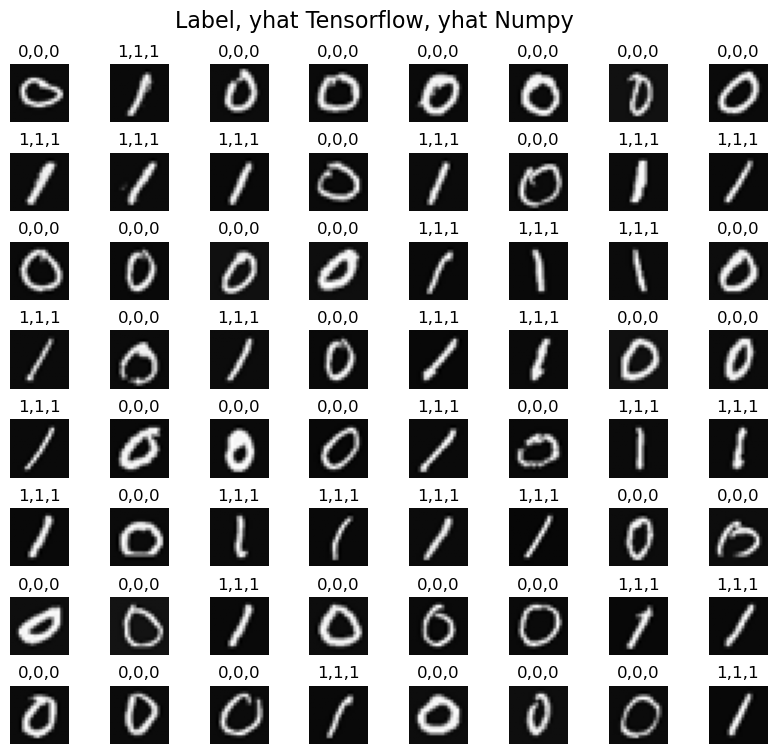

In [320]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')

    # Predict using the Neural Network implemented in Numpy
    my_prediction = my_sequential(X[random_index], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
    # my_yhat = int(my_prediction[0] >= 0.5)
    my_yhat = int((my_prediction >= 0.5).item())
    '''
    But my_prediction is probably an array (like array([[0.93]])), so my_prediction >= 0.5 
    becomes an array too, and int(array) is deprecated and will eventually fail.
    '''
    # Predict using the Neural Network implemented in Tensorflow
    tf_prediction = model.predict(X[random_index].reshape(1,400))
    # tf_yhat = int(tf_prediction >= 0.5)
    tf_yhat = int((tf_prediction >= 0.5).item())

    
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{tf_yhat},{my_yhat}")
    ax.set_axis_off() 
fig.suptitle("Label, yhat Tensorflow, yhat Numpy", fontsize=16)
plt.show()

<a name="2.6"></a>
### 2.6 Vectorized NumPy Model Implementation (Optional)
The optional lectures described vector and matrix operations that can be used to speed the calculations.
Below describes a layer operation that computes the output for all units in a layer on a given input example:

<img src="images/C2_W1_VectorMatrix.PNG" width="600" height="450">

We can demonstrate this using the examples `X` and the `W1`,`b1` parameters above. We use `np.matmul` to perform the matrix multiply. Note, the dimensions of x and W must be compatible as shown in the diagram above.

In [ ]:
print(X.shape)
print(X[0].shape) #(400,)

(1000, 400)
(400,)


In [ ]:
x = X[0].reshape(-1,1)         # column vector (400,1)
z1 = np.matmul(x.T,W1) + b1    # (1,400)(400,25) = (1,25).   #b1 shape = (25,)
a1 = sigmoid(z1)    #sigmoid function imported from utils.py is already vectorized by design.
print(a1.shape)

(1, 25)


or

In [ ]:
x = X[0].reshape(1,-1)         # column vector (1, 400)
z1 = np.matmul(x,W1) + b1    # (1,400)(400,25) = (1,25)
a1 = sigmoid(z1) #sigmoid function imported from utils.py is already vectorized by design.
print(a1.shape)

(1, 25)


You can take this a step further and compute all the units for all examples in one Matrix-Matrix operation.

<img src="images/C2_W1_MatrixMatrix.PNG" width="600" height="450">. 

The full operation is $\mathbf{Z}=\mathbf{XW}+\mathbf{b}$. This will utilize NumPy broadcasting to expand $\mathbf{b}$ to $m$ rows. If this is unfamiliar, a short tutorial is provided at the end of the notebook.

<a name="ex03"></a>
### Exercise 3

Below, compose a new `my_dense_v` subroutine that performs the layer calculations for a matrix of examples. This will utilize `np.matmul()`.

_**Note**: This function is not graded because it is discussed in the optional lectures on vectorization. If you didn't go through them, feel free to click the hints below the expected code to see the code. You can also submit the notebook even with a blank answer here._

In [ ]:
# UNQ_C3
# UNGRADED FUNCTION: my_dense_v

# This does the same as the my_dense function I wrote myself earlier. search: #vectorized version (use matrix operations (vectorization) instead of a loop.)
def my_dense_v(A_in, W, b, g):
    """
    Computes dense layer
    Args:
      A_in (ndarray (m,n)) : Data, m examples, n features each
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (1,j)) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      A_out (tf.Tensor or ndarray (m,j)) : m examples, j units
    """
    ### START CODE HERE ###
    Z = np.matmul(A_in,W) +b
    A_out = g(Z)
    # #or
    # A_out = sigmoid(Z)
    ### END CODE HERE ### 
    return(A_out)

In [424]:
X_tst = 0.1*np.arange(1,9,1).reshape(4,2) # (4 examples, 2 features)
W_tst = 0.1*np.arange(1,7,1).reshape(2,3) # (2 input features, 3 output features)
b_tst = 0.1*np.arange(1,4,1).reshape(1,3) # (1,3 features)
A_tst = my_dense(X_tst, W_tst, b_tst, sigmoid)
print(A_tst)

[[0.54735762 0.57932425 0.61063923]
 [0.57199613 0.61301418 0.65248946]
 [0.5962827  0.64565631 0.6921095 ]
 [0.62010643 0.67699586 0.72908792]]


In [423]:
X_tst = 0.1*np.arange(1,9,1).reshape(4,2) # (4 examples, 2 features)
W_tst = 0.1*np.arange(1,7,1).reshape(2,3) # (2 input features, 3 output features)
b_tst = 0.1*np.arange(1,4,1).reshape(1,3) # (1,3 features)
A_tst = my_dense_v(X_tst, W_tst, b_tst, sigmoid)
print(A_tst)

[[0.54735762 0.57932425 0.61063923]
 [0.57199613 0.61301418 0.65248946]
 [0.5962827  0.64565631 0.6921095 ]
 [0.62010643 0.67699586 0.72908792]]


**Expected Output**

```
[[0.54735762 0.57932425 0.61063923]
 [0.57199613 0.61301418 0.65248946]
 [0.5962827  0.64565631 0.6921095 ]
 [0.62010643 0.67699586 0.72908792]]
 ```

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    In matrix form, this can be written in one or two lines. 
    
       Z = np.matmul of A_in and W plus b    
       A_out is g(Z)  
<details>
  <summary><font size="3" color="darkgreen"><b>Click for code</b></font></summary>

```python
def my_dense_v(A_in, W, b, g):
    """
    Computes dense layer
    Args:
      A_in (ndarray (m,n)) : Data, m examples, n features each
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j,1)) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      A_out (ndarray (m,j)) : m examples, j units
    """
    Z = np.matmul(A_in,W) + b    
    A_out = g(Z)                 
    return(A_out)
```


In [334]:
# UNIT TESTS

test_c3(my_dense_v)

All tests passed!


The following cell builds a three-layer neural network utilizing the `my_dense_v` subroutine above.

In [343]:
def my_sequential_v(X, W1, b1, W2, b2, W3, b3):
    A1 = my_dense_v(X,  W1, b1, sigmoid)  #(1000, 25)
    A2 = my_dense_v(A1, W2, b2, sigmoid)  #(1000, 15)
    A3 = my_dense_v(A2, W3, b3, sigmoid)   #(1000, 1)
    return(A3)

We can again copy trained weights and biases from Tensorflow.

In [337]:
W1_tmp,b1_tmp = layer1.get_weights()
W2_tmp,b2_tmp = layer2.get_weights()
W3_tmp,b3_tmp = layer3.get_weights()

Let's make a prediction with the new model. This will make a prediction on *all of the examples at once*. Note the shape of the output.

In [344]:
Prediction = my_sequential_v(X, W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
Prediction.shape

(1000, 1)

We'll apply a threshold of 0.5 as before, but to all predictions at once.

In [346]:
Yhat = (Prediction >= 0.5).astype(int)
print("predict a zero: ",Yhat[0], "predict a one: ", Yhat[500])
Yhat.shape

predict a zero:  [0] predict a one:  [1]


(1000, 1)

Run the following cell to see predictions. This will use the predictions we just calculated above. This takes a moment to run.

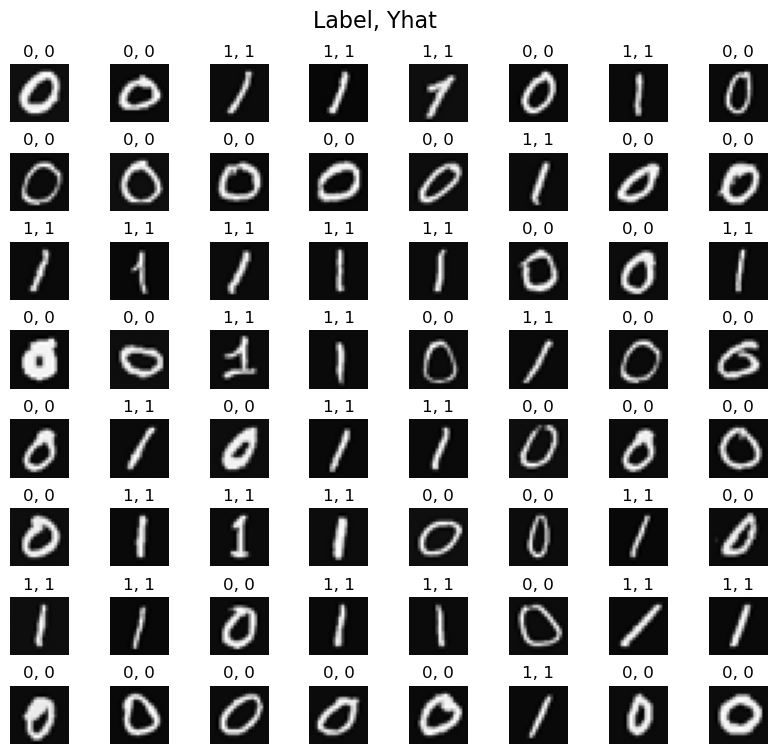

In [347]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i, ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20, 20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
   
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]}, {Yhat[random_index, 0]}")
    ax.set_axis_off() 
fig.suptitle("Label, Yhat", fontsize=16)
plt.show()

You can see how one of the misclassified images looks.

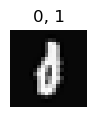

In [ ]:
# This block of code visualizes a misclassified image from a dataset:
fig = plt.figure(figsize=(1, 1)) #Creates a small figure for displaying one image. figsize=(1,1) sets the size of the figure in inches (very small image display).
errors = np.where(y != Yhat)
'''
Finds the indices where the predicted labels Yhat do not match the true labels y.
errors is a tuple (e.g., (array([3, 15, 47, ...]),)), containing indices of misclassified examples.
'''
random_index = errors[0][0]
'''
Selects the first index from the list of misclassified samples.
You could also randomize it with np.random.choice(errors[0]).
'''
X_random_reshaped = X[random_index].reshape((20, 20)).T
plt.imshow(X_random_reshaped, cmap='gray')
plt.title(f"{y[random_index,0]}, {Yhat[random_index, 0]}")
plt.axis('off')
plt.show()

In [381]:
print(y.shape)
print(Yhat.shape)

(1000, 1)
(1000, 1)


In [ ]:
print(errors)
#output:    (array([142]), array([0]))
# It means:
# array([142]) → the row indices where y[i, j] != Yhat[i, j]
# array([0]) → the column indices where y[i, j] != Yhat[i, j]
# So, this tells you that at position (142, 0) in the arrays, the values differ — meaning the model made a misclassification on the 143rd example (Python uses 0-based indexing).

(array([142]), array([0]))
[142]


np.int64(142)

<a name="2.7"></a>
### 2.7 Congratulations!
You have successfully built and utilized a neural network.

<a name="2.8"></a>
### 2.8 NumPy Broadcasting Tutorial (Optional)


In the last example,  $\mathbf{Z}=\mathbf{XW} + \mathbf{b}$ utilized NumPy broadcasting to expand the vector $\mathbf{b}$. If you are not familiar with NumPy Broadcasting, this short tutorial is provided.

$\mathbf{XW}$  is a matrix-matrix operation with dimensions $(m,j_1)(j_1,j_2)$ which results in a matrix with dimension  $(m,j_2)$. To that, we add a vector $\mathbf{b}$ with dimension $(1,j_2)$.  $\mathbf{b}$ must be expanded to be a $(m,j_2)$ matrix for this element-wise operation to make sense. This expansion is accomplished for you by NumPy broadcasting.

Broadcasting applies to element-wise operations.  
Its basic operation is to 'stretch' a smaller dimension by replicating elements to match a larger dimension.

More [specifically](https://NumPy.org/doc/stable/user/basics.broadcasting.html): 
When operating on two arrays, NumPy compares their shapes element-wise. It starts with the trailing (i.e. rightmost) dimensions and works its way left. Two dimensions are compatible when
- they are equal, or
- one of them is 1   

If these conditions are not met, a ValueError: operands could not be broadcast together exception is thrown, indicating that the arrays have incompatible shapes. The size of the resulting array is the size that is not 1 along each axis of the inputs.

Here are some examples:

<figure>
    <center> <img src="./images/C2_W1_Assign1_BroadcastIndexes.PNG"  alt='missing' width="400"  ><center/>
    <figcaption>Calculating Broadcast Result shape</figcaption>
<figure/>

The graphic below describes expanding dimensions. Note the red text below:

<figure>
    <center> <img src="./images/C2_W1_Assign1_Broadcasting.gif"  alt='missing' width="600"  ><center/>
    <figcaption>Broadcast notionally expands arguments to match for element wise operations</figcaption>
<figure/>

The graphic above shows NumPy expanding the arguments to match before the final operation. Note that this is a notional description. The actual mechanics of NumPy operation choose the most efficient implementation.

For each of the following examples, try to guess the size of the result before running the example.

In [ ]:
a = np.array([1,2,3]).reshape(-1,1)  #(3,1)
b = 5 
print(f"(a + b).shape: {(a + b).shape}, \na + b = \n{a + b}")

(a + b).shape: (3, 1), 
a + b = 
[[6]
 [7]
 [8]]


Note that this applies to all element-wise operations:

In [ ]:
a = np.array([1,2,3]).reshape(-1,1)  #(3,1)
b = 5
'''
Even though b is a scalar (shape ()), NumPy conceptually expands it to match the shape of a — that is, it acts as if b were:
[[5],
 [5],
 [5]]
✅ Why it works:
Scalars have shape () and can be broadcast to any shape, including (3,1). So NumPy does this:
a (3,1) × b () → broadcast b to shape (3,1) → ✅ elementwise multiplication
No shape mismatch — just scalar expansion.
'''
print(f"(a * b).shape: {(a * b).shape}, \na * b = \n{a * b}")

(a * b).shape: (3, 1), 
a * b = 
[[ 5]
 [10]
 [15]]


<details>
  <summary><b style="color:red;">NumPy Multiplication: Elementwise vs. Matrix Multiplication</b></summary>

#### Same Shape: Elementwise Multiplication  

In NumPy, when you do:
```python
(1, n) * (1, n)

or (n, 1) * (n, 1)
```
They are the same shape, so NumPy does elementwise multiplication, not matrix multiplication.  

- **When two arrays have identical shapes (e.g., `(1, n)` and `(1, n)` or `(n, 1)` and `(n, 1)`), NumPy performs elementwise multiplication with the `*` operator.**

**Examples:**

1. **(1, n) \* (1, n)**
    ```python
    a = np.array([[1,   # shape (1, 3)
    b = np.array([[4,   # shape (1, 3)
    print(a * b)  # Output: []
    ```

2. **(n, 1) \* (n, 1)**
    ```python
    a = np.array([, , ])  # shape (3, 1)
    b = np.array([, , ])  # shape (3, 1)
    print(a * b)  # Output: [, , ]
    ```

#### Matrix Multiplication (`@`) Requires Compatible Shapes

- **Matrix multiplication (using `@`) requires the "inner" dimensions to match.**
- For `(n, 1) @ (n, 1)`, this fails (shape mismatch).
```python
a = np.array([, , ]) # shape (3, 1)
b = np.array([, , ]) # shape (3, 1)
```
a @ b # ❌ Error: shapes (3,1) and (3,1) not aligned

**To perform matrix multiplication, adjust shapes with a transpose:**
```python
(1, 3) @ (3, 1) → (1, 1)
a = np.array([[1, 2, # shape (1, 3)
b = np.array([, , ]) # shape (3, 1)
result = a @ b # Output: []
```

### Quick Reference Table

| Shape A    | Shape B    | `*` (elementwise)?           | `@` (matrix product)?                |
|------------|------------|------------------------------|--------------------------------------|
| (1, n)     | (1, n)     | ✅ Yes                       | ❌ No (shape mismatch)               |
| (n, 1)     | (n, 1)     | ✅ Yes                       | ❌ No (shape mismatch)               |
| (1, n)     | (n, 1)     | ✅ Outer product (n x n)     | ✅ @ yields (1, 1)                   |
| (n,)       | (n,)       | ✅ Yes                       | ✅ Dot product (scalar)              |
| (n, 1)     | (1, n)     | ✅ Outer product (n x n)     | ✅ @ yields (n, n)                   |


### Key Points

- **`*` operator does elementwise multiplication** if shapes are the same or broadcastable.
- **`@` operator (matrix multiplication)** requires compatible inner dimensions for linear algebra rules.
- Use `.T` to transpose arrays when their shapes don’t match for matrix multiplication.
</details>

<figure>
    <img src="./images/C2_W1_Assign1_VectorAdd.PNG"  alt='missing' width="740" >
    <center><figcaption><b>Row-Column Element-Wise Operations</b></figcaption></center>
<figure/>

In [386]:
a = np.array([1,2,3,4]).reshape(-1,1) #(4, 1)
b = np.array([1,2,3]).reshape(1,-1) #(1, 3)
print(a)
print(b)
print(f"(a + b).shape: {(a + b).shape}, \na + b = \n{a + b}")

[[1]
 [2]
 [3]
 [4]]
[[1 2 3]]
(a + b).shape: (4, 3), 
a + b = 
[[2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]]


In [388]:
a = np.array([1,2,3,4]).reshape(-1,1) #(4, 1)
b = np.array([1,2,3]).reshape(1,-1) #(1, 3)
print(a)
print(b)
print(f"(a * b).shape: {(a * b).shape}, \na * b = \n{a * b}")

[[1]
 [2]
 [3]
 [4]]
[[1 2 3]]
(a * b).shape: (4, 3), 
a * b = 
[[ 1  2  3]
 [ 2  4  6]
 [ 3  6  9]
 [ 4  8 12]]


In [389]:
a = np.array([1,2,3,4]).reshape(-1,1) #(4, 1)
b = np.array([1,2,3]).reshape(1,-1) #(1, 3)
print(a)
print(b)
print(f"(a * b).shape: {(a @ b).shape}, \na * b = \n{a @ b}")

[[1]
 [2]
 [3]
 [4]]
[[1 2 3]]
(a * b).shape: (4, 3), 
a * b = 
[[ 1  2  3]
 [ 2  4  6]
 [ 3  6  9]
 [ 4  8 12]]


This is the scenario in the dense layer you built above. Adding a 1-D vector $b$ to a (m,j) matrix.
<figure>
    <img src="./images/C2_W1_Assign1_BroadcastMatrix.PNG"  alt='missing' width="740" >
    <center><figcaption><b>Matrix + 1-D Vector</b></figcaption></center>
<figure/>

<details>
  <summary><font size="2" color="darkgreen"><b>Please click here if you want to experiment with any of the non-graded code.</b></font></summary>
    <p><i><b>Important Note: Please only do this when you've already passed the assignment to avoid problems with the autograder.</b></i>
    <ol>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “Edit Metadata”</li>
        <li> Hit the “Edit Metadata” button next to the code cell which you want to lock/unlock</li>
        <li> Set the attribute value for “editable” to:
            <ul>
                <li> “true” if you want to unlock it </li>
                <li> “false” if you want to lock it </li>
            </ul>
        </li>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “None” </li>
    </ol>
    <p> Here's a short demo of how to do the steps above: 
        <br>
        <img src="https://drive.google.com/uc?export=view&id=14Xy_Mb17CZVgzVAgq7NCjMVBvSae3xO1" align="center" alt="unlock_cells.gif">
</details>